In [1]:
import torch
import h5py
import os
import numpy as np
from torch import nn as nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from d2l import torch as d2l

In [3]:
import matplotlib.pyplot as plt

In [4]:
# get the file name of path
def get_fname(path):
    files = os.listdir(path)
    files.sort()
    return files

In [179]:
def get_fpath(path, fname):
    return os.path.join(path, fname)

def get_hdf5_group(hdf5File):
    group = []
    for key in hdf5File:
        group.append(key)
    return group

In [180]:
def plot_(x, y, xlabel, ylabel):
    plt.scatter(x, y)
    #plt.plot(x, y, color)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [181]:
filesDir = get_fname(data_dir)

In [182]:
filesDir.sort()

In [183]:
filesDir

['test', 'train', 'valid']

In [184]:
len(files)

3

In [98]:
# =================================
# ======Particle Data Sequence=====
# =================================
# 1.ParticleIDs 2.Masses 3.Density 4.InternalEnergy 
# 5.Potential 6.SmoothingLength 7.Coordinates 8.Velocities

In [201]:
# ids, masses, density, smoothingLength, coordinates, Velocities(x)

In [185]:
trainFiles = get_fname(get_fpath(data_dir, filesDir[1]))

In [186]:
len(trainFiles)

5999

In [187]:
validFiles = get_fname(get_fpath(data_dir, filesDir[2]))

In [188]:
len(validFiles)

1000

question 1 把数据中的质量、密度、坐标、速度（光滑半径）提取出来

In [190]:
# physcial quantity squence is ids mass rho ie pot sl pos*3 vel*3
def chose_input_output_phy_qua(data, phy_qua):
    assert phy_qua == "mass" or phy_qua == "rho" or phy_qua == "ie" or phy_qua == "pot" or phy_qua == "sl" or phy_qua == "pos" or phy_qua == "vel"
    if phy_qua == "mass":
        return data[:, 1]
    if phy_qua == "rho":
        return data[:, 2]
    if phy_qua == "ie":
        return data[:, 3]
    if phy_qua == "pot":
        return data[:, 4]
    if phy_qua == "rho":
        return data[:, 5]
    if phy_qua == "pos":
        return data[:, -6:-3]
    if phy_qua == "vel":
        return data[:, -3:]

In [206]:
testDir = data_dir + "/train"
testFiles = get_fname(testDir)
test0 = h5py.File(get_fpath(testDir, testFiles[0]))
test1 = h5py.File(get_fpath(testDir, testFiles[1]))

In [207]:
test0["dataset"][0], test0["dataset"][0].shape

(array([ 1.0000000e+00,  2.9456370e+21,  7.9943233e+00,  2.4651726e+07,
        -1.6436408e+08,  2.7425510e+02], dtype=float32),
 (6,))

In [208]:
test0["dataset"][1], test0["dataset"][1].shape

(array([ 1.0000000e+00,  2.9456370e+21,  7.9846368e+00,  2.4659982e+07,
        -1.6435805e+08,  2.0752586e+01], dtype=float32),
 (6,))

In [209]:
test1["dataset"][0], test1["dataset"][0].shape

(array([ 1.0000000e+01,  2.9456370e+21,  8.0024481e+00,  2.4640620e+07,
        -1.6455928e+08,  2.9160733e+02], dtype=float32),
 (6,))

In [210]:
test1["dataset"][1], test1["dataset"][1].shape

(array([ 1.0000000e+01,  2.9456370e+21,  8.0043898e+00,  2.4638858e+07,
        -1.6450915e+08,  1.2152153e+03], dtype=float32),
 (6,))

In [215]:
abs(test1["dataset"][0][4] - test0["dataset"][0][4]), test0["dataset"][0][3]

(195200.0, 24651726.0)

question 2 算出位移

In [216]:
aaa = h5py.File("../../datasets_PINNs/dataset_preDeal/snapshot_000.hdf5")

In [220]:
aaa["dataset"][:].shape

(242311, 6)

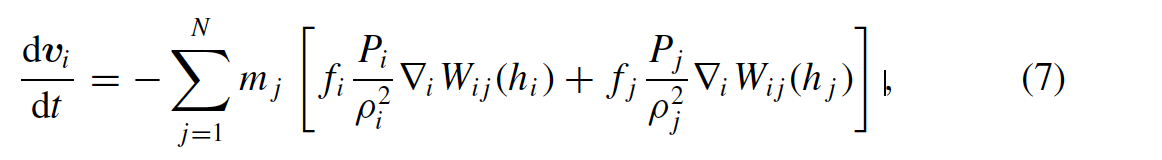

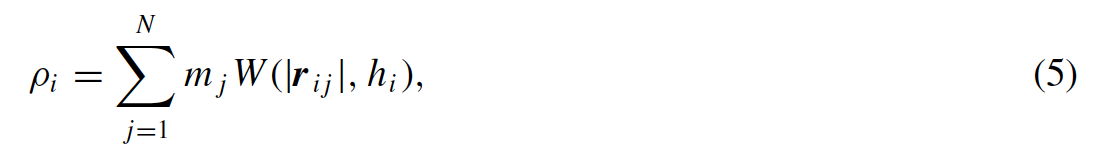

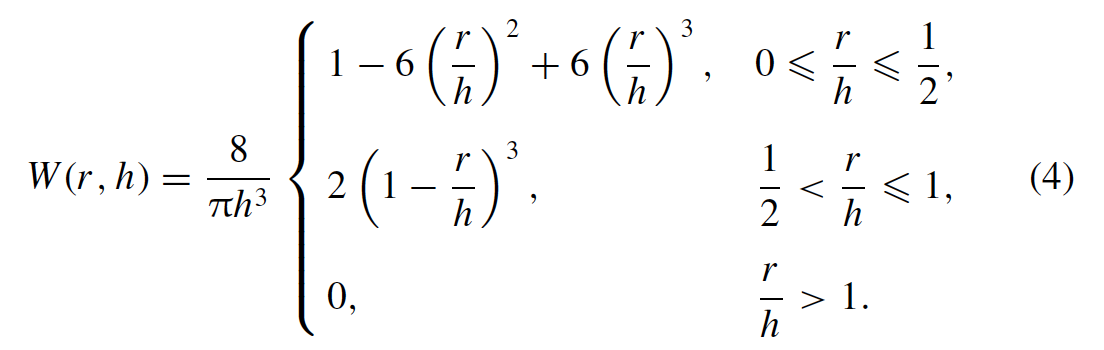

In [130]:
# masses/density/smoothing length /coordinates --> vel

思路：
    1.训练一个粒子的全过程，也就是将afterDeal作为网络的训练数据
    
      2.然后将preDeal数据作为损失函数的训练部分


In [224]:
# files dir

#train
data_dir = "../../datasets_PINNs/"
nnDataDir = data_dir + "dataset_afterDeal/"
trainDataDir = nnDataDir + "train/"
validDataDir = nnDataDir + "valid/"
testDataDir = nnDataDir + "test/"

#loss
lossDataDir = data_dir + "dataset_preDeal/"

In [225]:
# 数据处理
nnTrainData = h5py.File(get_fpath(trainDataDir, "particleID1.hdf5"))
lossTrainData = h5py.File(get_fpath(lossDataDir, "snapshot_000.hdf5"))

In [67]:
class ResidualBlock(nn.Module):
    """Residual Block with Linear Layers"""
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
    
    def forward(self, x):
        return x + self.main(x)


class DNN(nn.Module):
    """Deep Neural Network"""
    def __init__(self, input_dim, hidden_dim, output_dim, repeat_num):
        super(DNN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU(inplace=True))
        
        # down-sampling
        curr_dim = hidden_dim
        for i in range(2):
            layers.append(nn.Linear(curr_dim, curr_dim*2))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2
            
        for i in range(repeat_num):
            layers.append(ResidualBlock(curr_dim))
            
        # up-sampling
        for i in range(2):
            layers.append(nn.Linear(curr_dim, curr_dim//2))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2
            
        layers.append(nn.Linear(curr_dim, curr_dim))
        layer.append(nn.Tanh())
        layers.append(nn.Linear(curr_dim, output_dim))
        
        self.main = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.main(x)

    
class NN_descriptor():
    pass

In [133]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
class PhysicsInformedNeuralNetwork_SPH(nn.Module):
    """The Physics Informed Neural Network"""
    def __init__(self):
        super(PhysicsInformedNeuralNetwork_SPH, self).__init__()
        
        #
        
    def W(self, r, h):
        """The spline kernel used in SPH((Monaghan & Lattanzio 1985)"""
        p = r / h
        sigma = 8 / (np.pi * h**3)
        if p > 1:
            return 0
        else if p > 1/2 and p <= 1:
            return 2 * sigma * (1 - p)**3
        else if p >= 0 and p <= 1/2:
            return sigma * (1 - 6 * p**2 + 6 * p**3)
    
    def W_grad(self, r, h):
        """The gradient of smoothing kernel: dW(r, h) = dW(r, h)/dr"""
        p = r / h
        sigma = 8 / (np.pi * h**3)
        if p > 1:
            return 0
        else if p > 1/2 and p <= 1:
            return -sigma * (6 / h) * (1 - p)**2
        else if p >= 0 and p <= 1/2:
            return 6 * sigma * 1 / h * (-2 * p + 3 * p**2)
    
    def getAdjacentParticle(x_i, x_j, h):
        """"
        Geting the particle which distence is less then smoothing length
            :x_i - the particle i x_dim coordinates;
            :x_j - the particle j x_dim coordinates;
            :h - the sommthing length of particle i;
        """
        if abs(x_i - x_j) <= h:
            return True
        else:
            return False
        
    def loss_NN(self):
        """The loss of the output of the neural network"""
        pass
    
    def loss_PDE(self):
        """The loss of the PDE: dv/dt(the output of NN) - PDE = 0 """
        pass
    
    def loss(self):
        pass
    
    def train(self):
        pass

In [ ]:
nn.

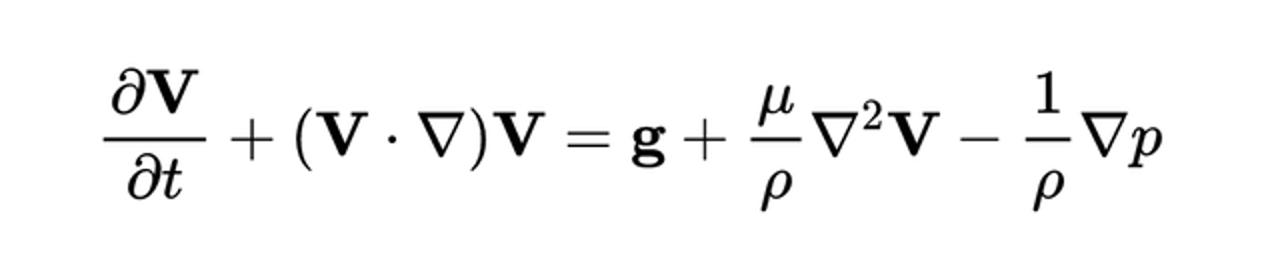

In [ ]:
class PhysicsInformedNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, repeat_num):
        super(PhysicsInformedNeuralNetwork, self).__init__()
        # boundary conditions
        # data
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural network
        self.dnn = DNN(input_dim, hidden_dim, output_dim, repeat_num).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
        # optimizers
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [ ]:
def get_net():
    #2-D x,y方向
    net = MyNetwork(2, 2)
    return net

In [103]:
# f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
# f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)
#@author: Maziar Raissi

In [ ]:
loss = nn.MSELoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
#             l, acc = d2l.train_batch_ch13(net, features, labels,
#                                           loss, trainer, devices)
            l, acc = train_batch(net, features, labels,
                                loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [11]:
# # f_test0 = h5py.File(get_fpath(data_dir, files[10]))
# data_test0 = f_test0[get_hdf5_group(f_test0)[0]] # 所有粒子混在一起的训练数据
# plot_(data_test0[:, 6], data_test0[:, 9], 'x', 'v')

# f_test1 = h5py.File(get_fpath(data_dir, files[677]))
# data_test1 = f_test1[get_hdf5_group(f_test1)[0]]
# plot_(np.linspace(start=0, stop=len(data_test0[:, 6]), num=len(data_test0[:, 6])), data_test1[:, 6], 'dis', 'x')

# plot_(np.linspace(0, len(data_test0[:, 9]), len(data_test0[:, 9])), data_test1[:, 9], 'dis', 'v')

# # This train shapest we just to use one snapshot just
# def data_ratio_select(data, data_len):
#     return data[0:2*data_len:2]

# data0 = data_ratio_select(data_test1, 5000)

# # get train set and validation set from the DATA
# def reorg_train_vaild(data, valid_ratio):
#     l = len(data)
#     # data = random.shuffle(data)
#     n = l-int(l*valid_ratio)
#     train_data = data[:n]
#     valid_data = data[n:]
#     return train_data, valid_data

# train_data0, valid_data0 = reorg_train_vaild(data0, 0.1)

# len(train_data0), len(valid_data0)

# # select the data for test
# def recorg_test(data, line, test_len):
#     return data[line:2*test_len:2]

# test_data0 = recorg_test(data_test1, 5000, 7500) 

# train_data0[0], valid_data0[0], test_data0[0]

# train_data0.shape, valid_data0.shape, test_data0.shape

# # physcial quantity squence is ids mass rho ie pot sl pos*3 vel*3
# def chose_input_output_phy_qua(data, phy_qua):
#     assert phy_qua == "mass" or phy_qua == "rho" or phy_qua == "ie" or phy_qua == "pot" or phy_qua == "sl" or phy_qua == "pos" or phy_qua == "vel"
#     if phy_qua == "mass":
#         return data[:, 1]
#     if phy_qua == "rho":
#         return data[:, 2]
#     if phy_qua == "ie":
#         return data[:, 3]
#     if phy_qua == "pot":
#         return data[:, 4]
#     if phy_qua == "rho":
#         return data[:, 5]
#     if phy_qua == "pos":
#         return data[:, -6:-3]
#     if phy_qua == "vel":
#         return data[:, -3:]
    
# train_data0_pos = chose_input_output_phy_qua(train_data0, "pos")
# train_data0_vel = chose_input_output_phy_qua(train_data0, "vel")

# valid_data0_pos = chose_input_output_phy_qua(valid_data0, "pos")
# valid_data0_vel = chose_input_output_phy_qua(valid_data0, "vel")

# test_data0_pos = chose_input_output_phy_qua(test_data0, "pos")
# test_data0_vel = chose_input_output_phy_qua(test_data0, "vel")

# # norm function for numpy
# def data_norm(data, delta):
#     mean = data.mean(axis=0, keepdims=True)
#     print('mean: ', mean.shape)
#     std = data.std(axis=0, keepdims=True)
#     print('std: ', std.shape)
#     print("================")
#     return (data-mean) / (std + delta)

# #train
# train_data0_pos_norm = data_norm(train_data0_pos, 0.000001)
# train_data0_vel_norm = data_norm(train_data0_vel, 0.000001)
# #valid
# valid_data0_pos_norm = data_norm(valid_data0_pos, 0.000001)
# valid_data0_vel_norm = data_norm(valid_data0_vel, 0.000001)
# #test
# test_data0_pos_norm = data_norm(test_data0_pos, 0.000001)
# test_data0_vel_norm = data_norm(test_data0_vel, 0.000001)

# plot_(np.linspace(0, len(train_data0_pos_norm[:, 0]), len(train_data0_pos_norm[:, 0])), train_data0_pos_norm[:, 0], 'dis', 'x')
# plot_(np.linspace(0, len(train_data0_vel_norm[:, 0]), len(train_data0_vel_norm[:, 0])), train_data0_vel_norm[:, 0], 'dis', 'v')

# plot_(train_data0_pos_norm[:, 0], train_data0_vel[:, 0], 'x', 'v')

# # 训练采用的数据为未处理的，所有粒子混在一起的粒子

# def data_to_tensor(data):
#     return torch.from_numpy(data)

# train_data0_pos_norm_t = data_to_tensor(train_data0_pos_norm)
# train_data0_vel_norm_t = data_to_tensor(train_data0_vel_norm)
# valid_data0_pos_norm_t = data_to_tensor(valid_data0_pos_norm)
# valid_data0_vel_norm_t = data_to_tensor(valid_data0_vel_norm)

# # defined SPH output Dataset
# class SPHDataset(Dataset):
#     def __init__(self, features, labels):
#         self.features = features
#         self.labels = labels
#     def __len__(self):
#         return len(self.features)
#     def __getitem__(self, item):
#         return self.features[item], self.labels[item]
    
# train_ds = SPHDataset(train_data0_pos_norm_t, train_data0_vel_norm_t)
# valid_ds = SPHDataset(valid_data0_pos_norm_t, valid_data0_vel_norm_t)

# batch_size = 32
# train_iter = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
# valid_iter = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# class ResidualBlock(nn.Module):
#     """Residual Block with Linear Layers"""
#     def __init__(self, dim):
#         super(ResidualBlock, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(dim, dim),
#             nn.BatchNorm1d(dim),
#             nn.ReLU(inplace=True),
#             nn.Linear(dim, dim),
#             nn.BatchNorm1d(dim)
#         )
    
#     def forward(self, x):
#         return x + self.main(x)


# class DNN(nn.Module):
#     """Deep Neural Network"""
#     def __init__(self, input_dim, hidden_dim, output_dim, repeat_num):
#         super(DNN, self).__init__()
        
#         layers = []
#         layers.append(nn.Linear(input_dim, hidden_dim))
#         layers.append(nn.ReLU(inplace=True))
        
#         # down-sampling
#         curr_dim = hidden_dim
#         for i in range(2):
#             layers.append(nn.Linear(curr_dim, curr_dim*2))
#             layers.append(nn.ReLU(inplace=True))
#             curr_dim = curr_dim * 2
            
#         for i in range(repeat_num):
#             layers.append(ResidualBlock(curr_dim))
            
#         # up-sampling
#         for i in range(2):
#             layers.append(nn.Linear(curr_dim, curr_dim//2))
#             layers.append(nn.ReLU(inplace=True))
#             curr_dim = curr_dim // 2
            
#         layers.append(nn.Linear(curr_dim, curr_dim))
#         layer.append(nn.Tanh())
#         layers.append(nn.Linear(curr_dim, output_dim))
        
#         self.main = nn.Sequential(*layers)
        
#     def forward(self, x):
#         return self.main(x)
    
# #     def loss_IC(self):
# #         pass
    
# #     def loss_BC(self):
# #         pass
    
# #     def loss_PDE(self):
# #         pass


# class PhysicsInformedNeuralNetwork_SPH(nn.Module):
#     """The Physics Informed Neural Network"""
#     def __init__(self):
#         super(PhysicsInformedNeuralNetwork_SPH, self).__init__()
        
#     def W(self, r, h):
#         """The spline kernel used in SPH((Monaghan & Lattanzio 1985)"""
#         p = r / h
#         sigma = 8 / (np.pi * h**3)
#         if p > 1:
#             return 0
#         else if p > 1/2 and p <= 1:
#             2 * sigma * (1 - p)**3
#         else if p >= 0 and p <= 1/2:
#             sigma * (1 - 6 * p**2 + 6 * p**3)
    
#     def W_grad(self, r, h):
#         """The gradient of smoothing kernel: dW(r, h) = (dW(r, h)/dr)/r"""
#         pass
    
#     def loss(self):
#         pass
    
#     def train(self):
#         pass
    
